In [1]:
#>> updated 4/1
# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries
import re
import math
import nltk
import spacy
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
import matplotlib.pyplot as plt

# Getting particular functions from these libraries
from scipy import stats
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin') or ('.gz'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}') #<< faster than doing api.load
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = True
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = True
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('VERBOSE:', text)
    return

showCellCompletion = True
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = True
accelerator = True

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

Amazon reviews file: /kaggle/input/amazon-product-reviews/Reviews.csv
Google news word to vec file: /kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
## Only run once
#>> Seems to need to be rerun after every Kaggle timeout.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
# Load data from CSV
#>>  3/13 needed to change the path as below
# path ='/kaggle/input/Reviews.csv'#"/kaggle/input/amazon-product-reviews/Reviews.csv"
data = pd.read_csv(reviews_file) # Use pandas to analyze data
showD('Amazon reviews loaded into Panda')

# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Amazon reviews loaded into Panda
VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3 

In [5]:
# Check for empty entries or missing data in each column
for column in data.columns:
    if data[column].isnull().values.any():
        print(f"Column '{column}' has empty entries or missing data.")
    else:
        print(f"Column '{column}' has no empty entries or missing data.")

Column 'Id' has no empty entries or missing data.
Column 'ProductId' has no empty entries or missing data.
Column 'UserId' has no empty entries or missing data.
Column 'ProfileName' has empty entries or missing data.
Column 'HelpfulnessNumerator' has no empty entries or missing data.
Column 'HelpfulnessDenominator' has no empty entries or missing data.
Column 'Score' has no empty entries or missing data.
Column 'Time' has no empty entries or missing data.
Column 'Summary' has empty entries or missing data.
Column 'Text' has no empty entries or missing data.


In [6]:
# Delete all columns except Score & text

del data['Id']
del data['ProductId']
del data['UserId']
del data['ProfileName']
del data['HelpfulnessNumerator']
del data['HelpfulnessDenominator']
del data['Time']
del data['Summary']


printv(f'Column names -\n {data.columns}\n') 


           
           

VERBOSE: Column names -
 Index(['Score', 'Text'], dtype='object')



In [7]:
'''
#Find short very positive and very negative reviews

for idx in range(2048):
    score = data['Score'][idx]
    size = len(data['Text'][idx])
    if  (score == 1 or score == 5) and size <= 100:
        print(f'{idx}. score: {score}; review: {data["Text"][idx]}')

#print(data['Score'][0])`
'''
# Indices of 10 very short reviews, 5 very positive, 5 very negative
keepers = [50, 62,  321, 482, 707, 949, 1557, 16126, 102974, 122152]

#create new data frame containing only the keepers
#
data_brief = pd.DataFrame(columns=['Score', 'Text'])
data_brief_row = 0
for row in keepers:
    data_brief.loc[data_brief_row] = data.iloc[row]
    data_brief_row += 1

printv(f'Number of reviews: {len(data_brief["Score"])}')
printv(f'First five rows -\n{data_brief.head()}')

del data #Not needed


VERBOSE: Number of reviews: 10
VERBOSE: First five rows -
  Score                                               Text
0     1  This oatmeal is not good. Its mushy, soft, I d...
1     1  Arrived in 6 days and were so stale i could no...
2     5  Put this in my husbands stocking for Christmas...
3     5  These chips are quite tasty and the price is r...
4     5  Nice amount of heat and smoke. Very tasty chip...


In [8]:
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.0 MB/s eta 0:00:0000:0100:01
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=50428 sha256=045392fc3f6156b03827f3a3635a163a602feba072338f342df4e5d52c744d7e
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [9]:
# custom stop words to remove
custom_stop_words =['a', 'about', 'above', 'after',  'all', 'am', 'an', 'and', 'any',
'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
'between', 'both', 'but', 'by', 'can',  'd', 'did',
 'do', 'does', 'doing', 'down',
'during', 'each', 'for', 'from', 'further', 'had', 'has',  'have', 'having',
'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how',
'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its',
'itself', 'just', 'll', 'm', 'ma', 'me',  'more',
'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't",
'nor',  'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's',
'same',  'she', "she's", 'so', 'some', 'such', 't', 'than', 'that',
"that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too',
'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we',
'were',  'what', 'when', 'where', 'which', 'while',
'who', 'whom', 'why', 'will', 'with', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your',
'yours', 'yourself', 'yourselves']

**Around 7 minutes for 5,000 reviews**

In [10]:
numeric = re.compile(r'\d+', re.UNICODE)
def isNumeric(token):
    global numeric
    if re.fullmatch(numeric, token): return True
    return False

In [11]:
import pkg_resources
from symspellpy import SymSpell

# Load the English tokenizer model from spaCy
nlp = spacy.load("en_core_web_lg")

# Compile the regular expressions for cleaning text
html_tags = re.compile("<.*?>")
punct_and_symbols = re.compile(r'[^\w\s\']+')

# Initialize and load SymSpell dictionary for word segmentation
sym_spell = SymSpell(max_dictionary_edit_distance = 0, prefix_length = 7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index = 0, count_index = 1)

def tokenizer(text, nlp, sym_spell, custom_stop_words):
    """
    Tokenizes a text string, segments run-on words, and removes stop words.
    
    text (str): The text string to tokenize.
    nlp: The spaCy language model.
    sym_spell: The SymSpell object for correcting run-on words.
    custom_stop_words (list): A list of custom stop words to remove.

    Returns:
        list: The tokenized text string.
    """
    # Clean text
    text = text.lower()  # Convert text to lowercase
    text = html_tags.sub("", text)  # Remove HTML tags
    text = punct_and_symbols.sub("", text)  # Replace punctuation and symbols with space
    # text = punct_and_symbols.sub(" ", text)  # Replace punctuation and symbols with space

    # Segment text using SymSpell
    segmented = sym_spell.word_segmentation(text)
    clean_text = segmented.corrected_string
    
    # Tokenize the text using spaCy
    doc = nlp(clean_text)

    # Remove stop words and punctuation tokens
    tokens = [token.text for token in doc if not token.is_punct 
              and token.text not in custom_stop_words
              and not isNumeric(token.text)] 

    return tokens

# Assuming 'balanced_data' is a pandas DataFrame with a column 'Text'
# Apply the tokenizer function to the 'Text' column
data_brief['CleanedReview'] = data_brief['Text'].apply(lambda x: tokenizer(x, nlp, sym_spell, custom_stop_words))

# Indicate completion
print('Tokenizer defined, and CleanedReview column created')

Tokenizer defined, and CleanedReview column created


In [12]:
# Store the Rating column
rating = data_brief['Score']  

# Store the CleanedReview column
tokenized_review = data_brief['CleanedReview']

for i in range (10):
    print(f"Score: {data_brief['Score'][i]}; Review: {data_brief['Text'][i]}")
    print(f'Tokenized review: {tokenized_review[i]}')
    print(f'Tokenized review length {len(tokenized_review[i])}\n')

Score: 1; Review: This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
Tokenized review: ['oatmeal', 'not', 'good', 'mushy', 'soft', "n't", 'like', 'quaker', 'oats', 'way', 'go']
Tokenized review length 11

Score: 1; Review: Arrived in 6 days and were so stale i could not eat any of the 6 bags!!
Tokenized review: ['arrived', 'days', 'stale', 'could', 'not', 'eat', 'bags']
Tokenized review length 7

Score: 5; Review: Put this in my husbands stocking for Christmas and it was a hit.
Tokenized review: ['put', 'husbands', 'stocking', 'christmas', 'hit']
Tokenized review length 5

Score: 5; Review: These chips are quite tasty and the price is right.  Packaged very well, would buy again.
Tokenized review: ['chips', 'quite', 'tasty', 'price', 'right', ' ', 'packaged', 'well', 'would', 'buy', 'again']
Tokenized review length 11

Score: 5; Review: Nice amount of heat and smoke. Very tasty chip that goes great with a brew.
Tokenized review: ['nice', 'amount', 

In [13]:
# >> 3/29/24 Took less than a minute to run without the accelerator.
# Load Word2Vec model
#w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load_word2vec_format (w2v_file, binary=True)

# Define the aimum sequence length (adjust as needed)
#>> Will increasing max_sequence_length impact performance?
max_sequence_length = 100

showD(f'{w2v} can map words onto vectors with 300 dimensions')

VERBOSE: KeyedVectors<vector_size=300, 3000000 keys> can map words onto vectors with 300 dimensions


In [14]:
# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")
    accelerator = True

else:
    accelerator = False
    print("CUDA is not available.")
    device = torch.device("cpu")
    print(device)

CUDA is not available.
cpu


In [15]:
#>> 3/29/24 Completed in less than 30 seconds using 1347 as max_sequence_length 


max_sequence_length = 100 
# Initialize an empty tensor for padded reviews on the GPU
padded_reviews = torch.zeros((len(tokenized_review), max_sequence_length, 300))

# Initialize a mask tensor of the same shape as padded_reviews
# Set it to False (or 0) initially, representing that all positions are padding
# mask = torch.zeros_like(padded_reviews, dtype=torch.bool)

# Initialize a mask tensor of the same shape as padded_reviews but with only sequence length
mask = torch.zeros((len(tokenized_review), max_sequence_length), dtype=torch.bool)

out_words = {}
words_in = 0
words_out = 0

# Now, during the padding and embedding conversion loop, update the mask as well
for i, review_tokens in enumerate(tokenized_review):
    review_length = min(len(review_tokens), max_sequence_length)
    for j in range(review_length):
        word = review_tokens[j]
        if word in w2v:
            words_in += 1
            # Use Word2Vec vector if available
            padded_reviews[i, j, :] = torch.tensor(w2v[word])
            mask[i, j] = True  # Update the mask to indicate the presence of a word
        else:
            words_out += 1
            out_words[word] = out_words.get(word, 0) + 1
        # Otherwise, the mask remains False (or 0) for padding

# Now you have a mask tensor that you can use later in your processing to ignore padded values
# For example, if you want to apply max pooling only on non-padded values, you could use:
# review_embeddings = torch.max(padded_reviews * mask.unsqueeze(-1).float(), dim=1)[0]

# Ensure the mask is treated as a float for any operations that require it
mask = mask.float()

# Now you can use this mask tensor to exclude the padding from any subsequent computations

printv(f'{words_in} words found with vector representations, {words_out} without')
printv(f'Number of unique words without vector representations: {len(out_words)}')
printd('Words without vector representations')
kwords = list(out_words.keys())
for idx in range(len(kwords)):
    kword = kwords[idx]
    freq = 'occurrences'
    if out_words[kword] == 1: 
        freq = 'occurrence'
    printd(f'"{kword}" - {out_words[kword]} {freq}')
# Apply max pooling to aggregate embeddings along the sequence dimension
# review_embeddings = torch.max(padded_reviews, dim=1)[0]

# Now,review_embeddings contains the aggregated Word2Vec 
# embeddings for each review on the GPU

printv(f'Example padded review: {padded_reviews[1]}')

showC(f"Created zero-padded, standard length reviews")

VERBOSE: 82 words found with vector representations, 1 without
VERBOSE: Number of unique words without vector representations: 1
DEV: Words without vector representations
DEV: " " - 1 occurrence
VERBOSE: Example padded review: tensor([[ 0.1543,  0.2676,  0.0933,  ..., -0.0928,  0.1367,  0.0391],
        [-0.1279,  0.2812,  0.0153,  ...,  0.1162,  0.0513, -0.0698],
        [ 0.1680,  0.1270, -0.1270,  ..., -0.0537, -0.3027,  0.1650],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [16]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
#>> to get the standard lenth
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
# rating_labels_tensors = torch.tensor(rating.values).to(device)
rating_labels_tensors = torch.tensor(rating).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

print(text_embeddings_tensors.shape)
print(rating_labels_tensors.shape)
print(text_embeddings_tensors.device)
print(rating_labels_tensors.device)
print(f'{rating_labels_tensors[0:-1]}')
print(dataset)

printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
print('\n\n\n\n\n\n\n\n\n\n')
if accelerator and showNv:
    print(torch.cuda.memory_summary())

torch.Size([10, 100, 300])
torch.Size([10])
cpu
cpu
tensor([1, 1, 5, 5, 5, 5, 5, 1, 1])
Total allocated memory: 0 bytes













In [34]:
from sklearn.manifold import TSNE

def tsne_plot(tokens,labels):
    "Creates and TSNE model and plots it"
  
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    unique_words = []
    plt.figure(figsize=(16, 16)) 
    for i in range(len(labels)):
        if labels[i] in unique_words:
            continue
        unique_words.append(labels[i])
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
showC(f'{tsne_plot} defined')

Cell complete: <function tsne_plot at 0x7cd4753f29e0> defined


Rating: 1; Review: This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
Tokenized text word-to-vector 2D scatter plot:


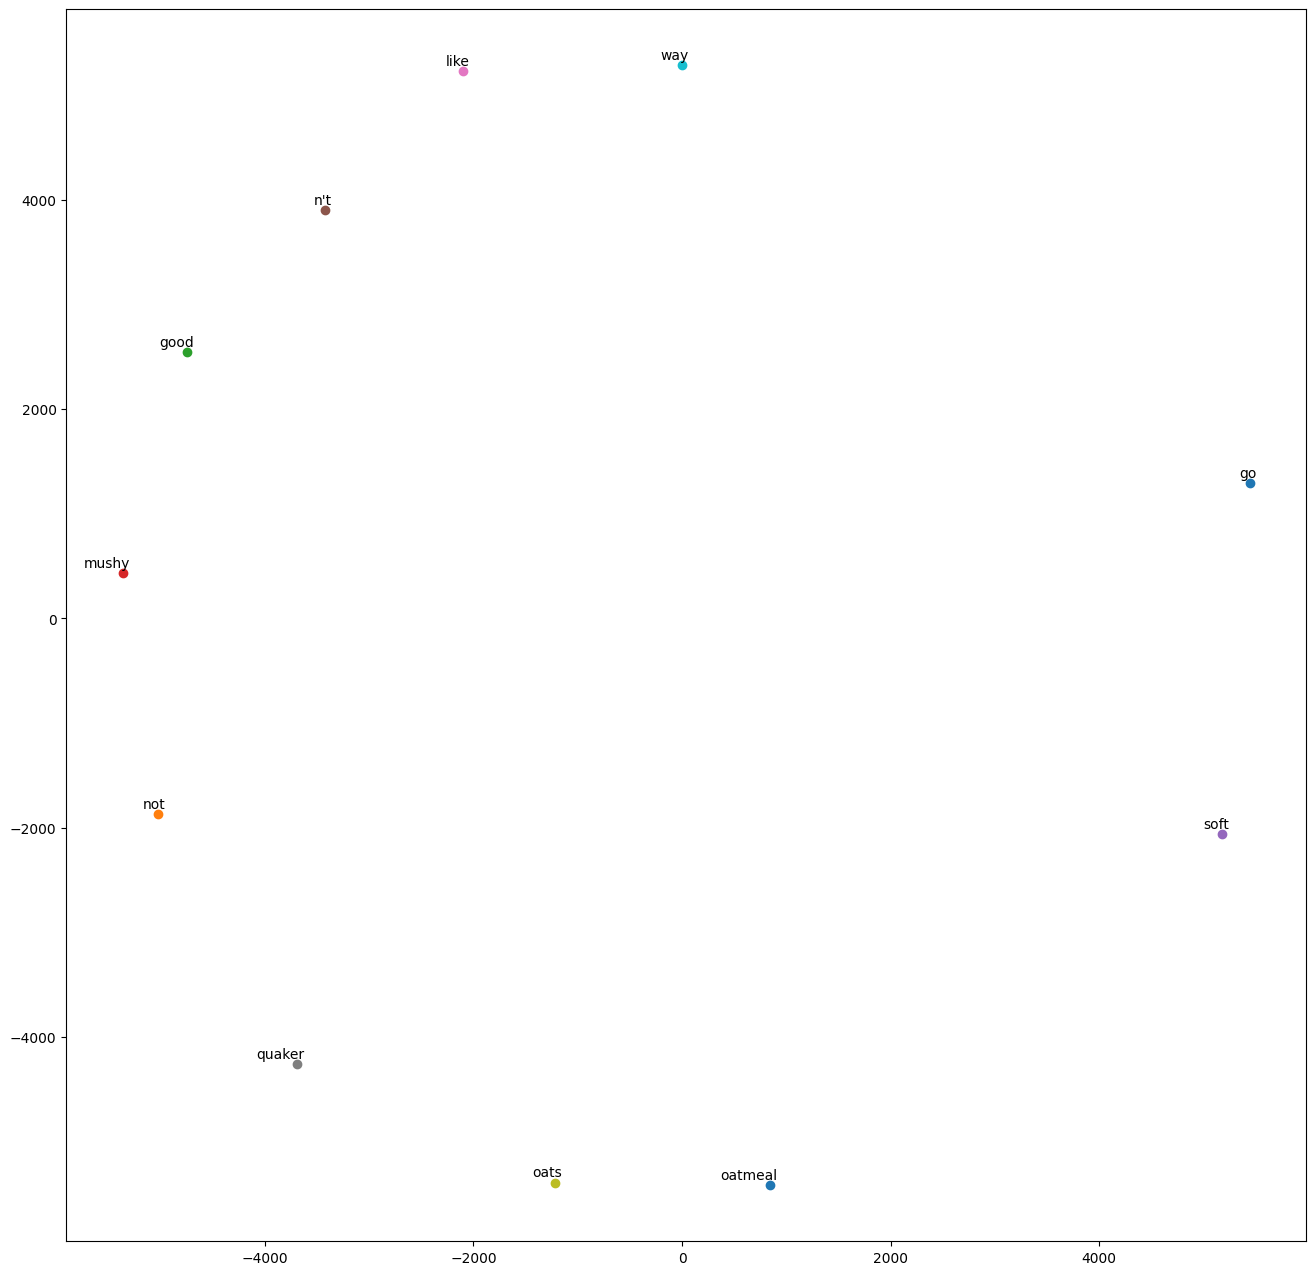




Rating: 1; Review: Arrived in 6 days and were so stale i could not eat any of the 6 bags!!
Tokenized text word-to-vector 2D scatter plot:


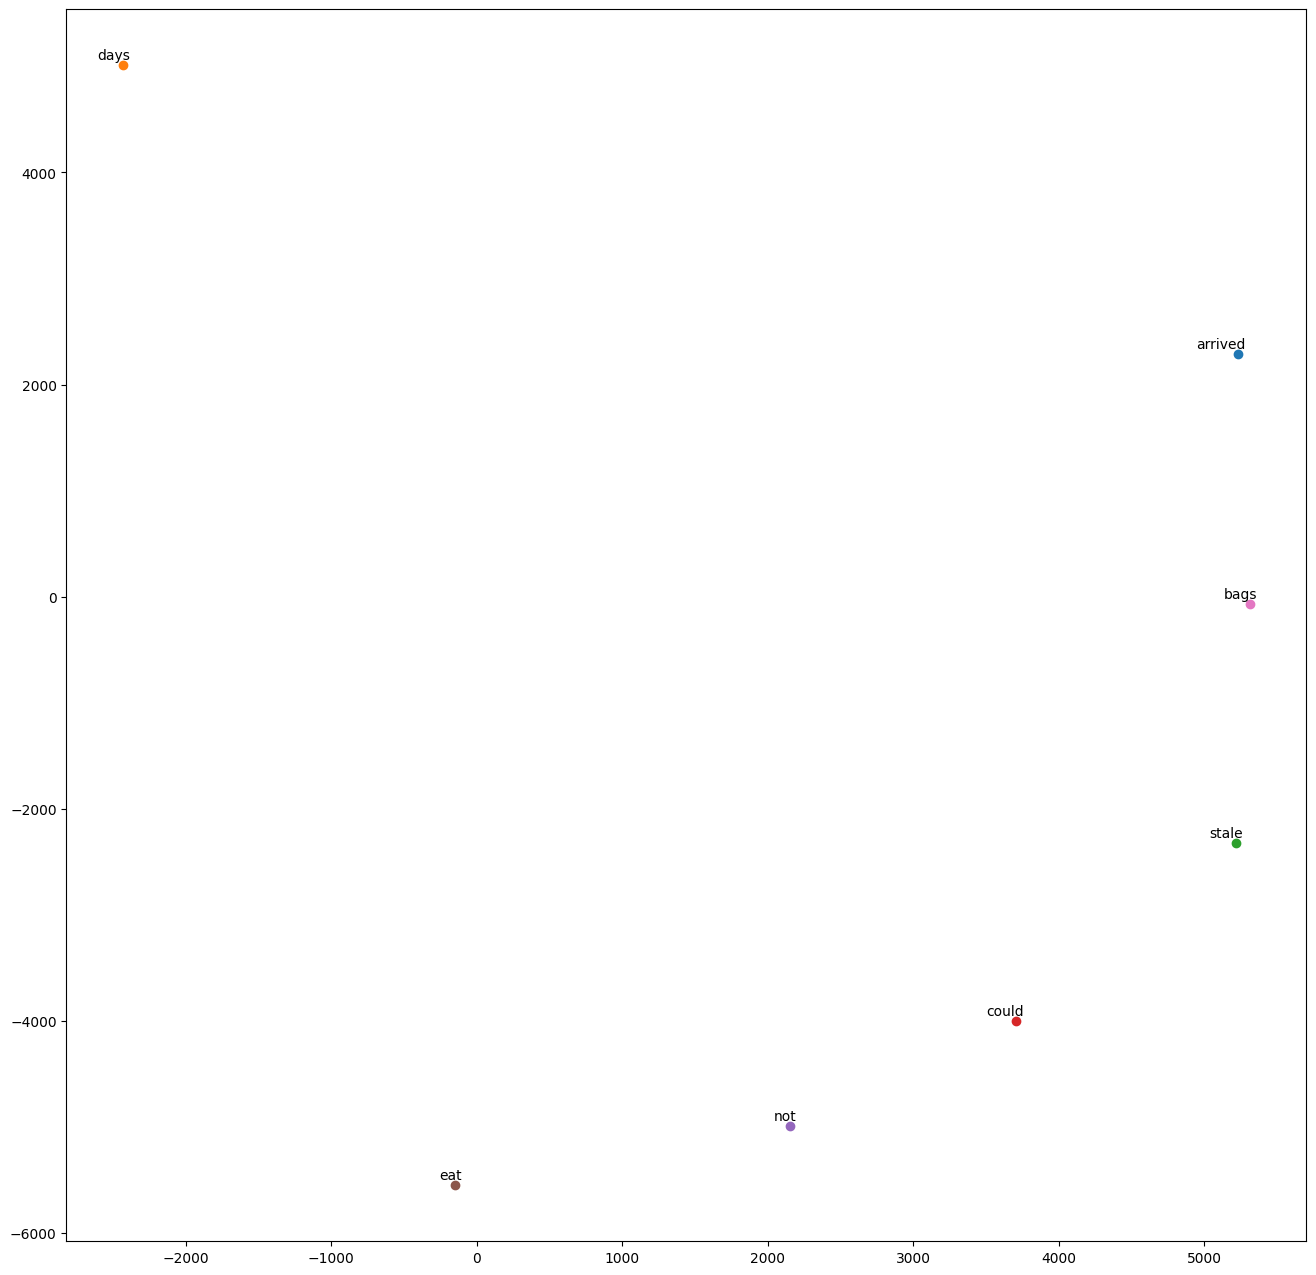




Rating: 5; Review: Put this in my husbands stocking for Christmas and it was a hit.
Tokenized text word-to-vector 2D scatter plot:


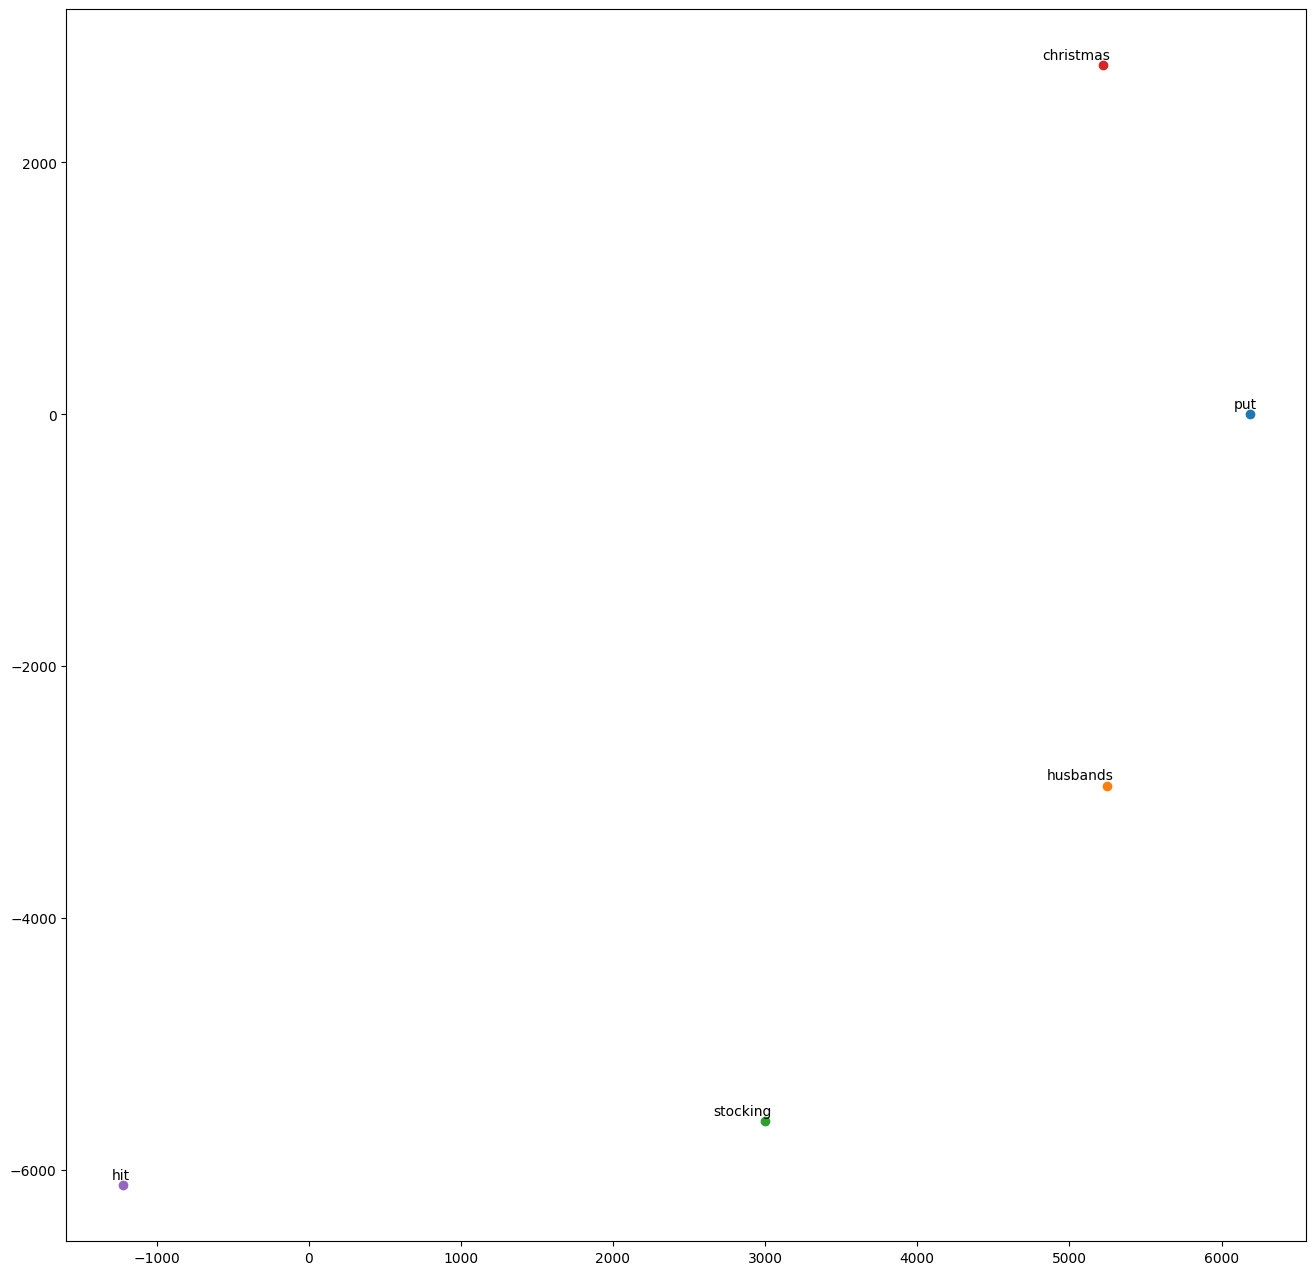




Rating: 5; Review: These chips are quite tasty and the price is right.  Packaged very well, would buy again.
Tokenized text word-to-vector 2D scatter plot:


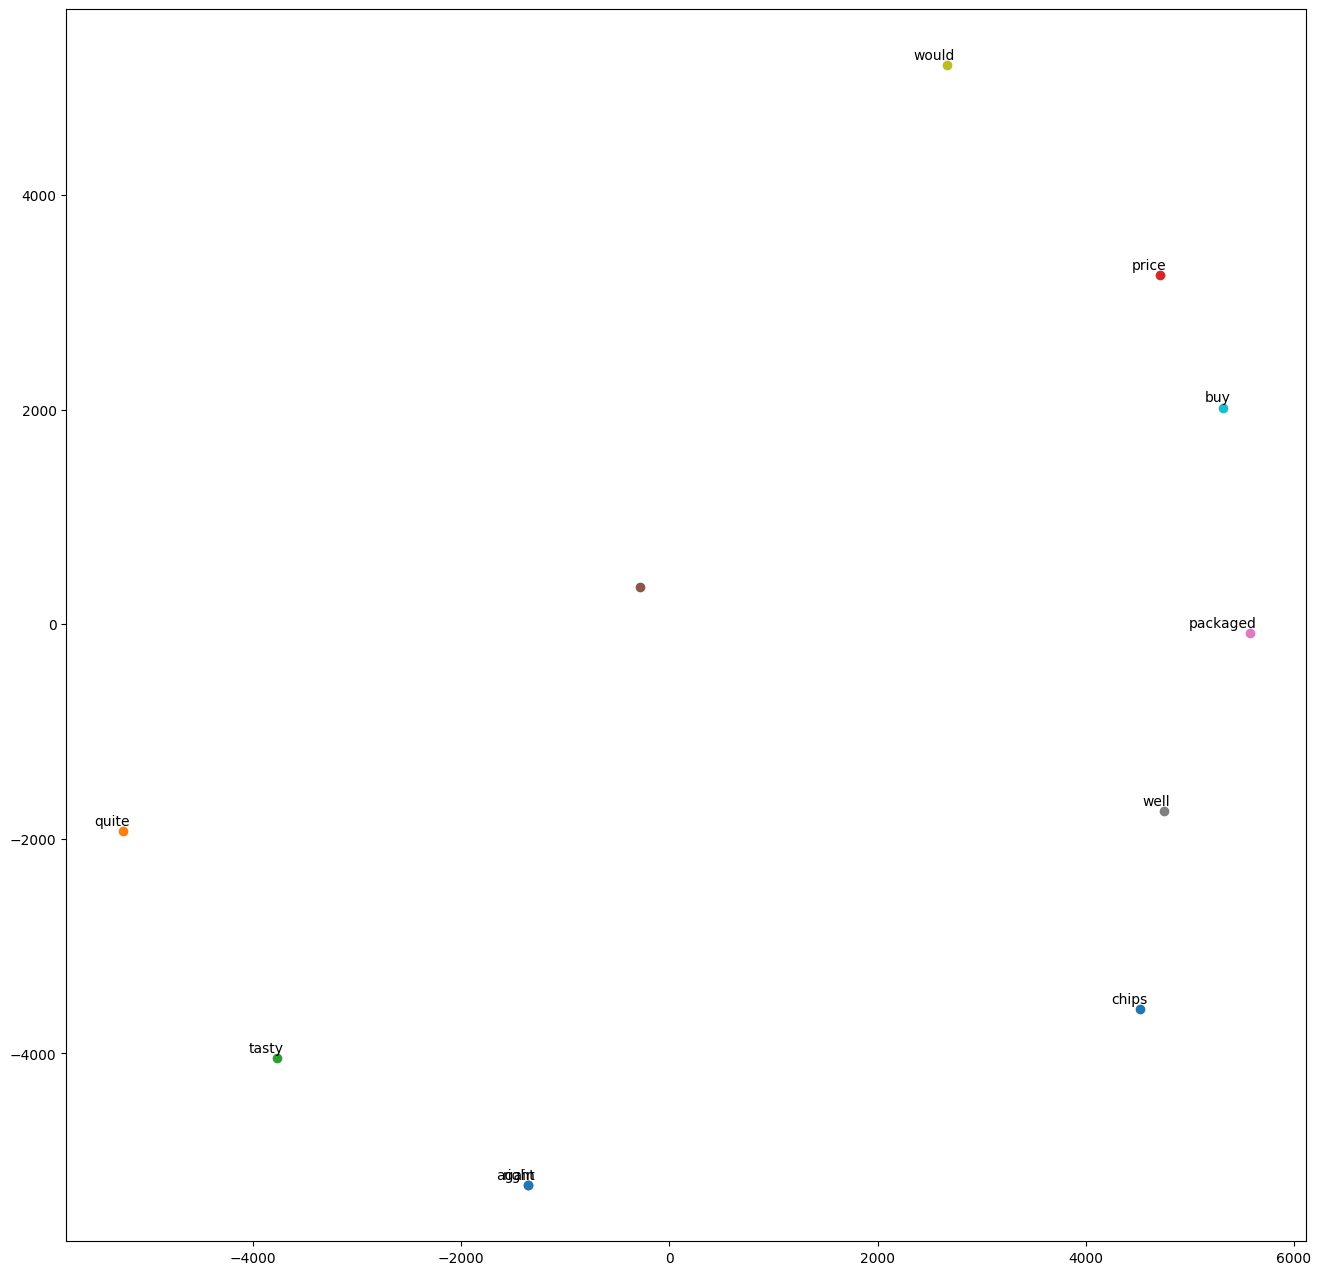




Rating: 5; Review: Nice amount of heat and smoke. Very tasty chip that goes great with a brew.
Tokenized text word-to-vector 2D scatter plot:


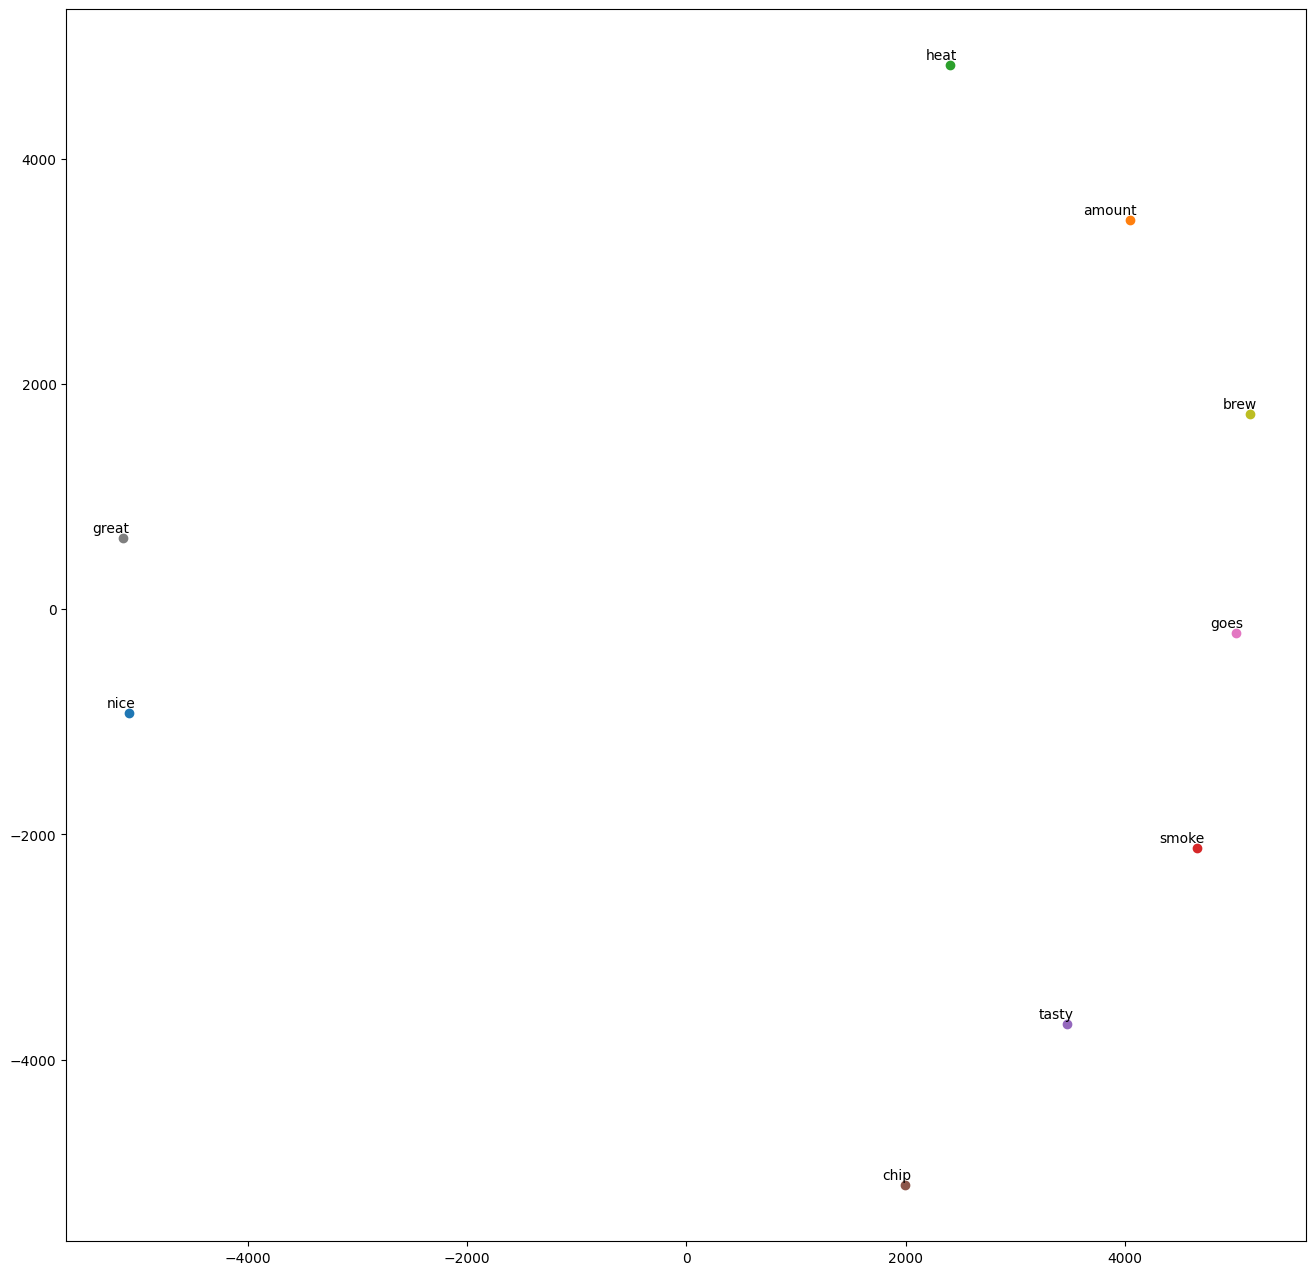




Rating: 5; Review: I am a true Seattle coffee addict, and I have never had a better coffee candy.
Tokenized text word-to-vector 2D scatter plot:


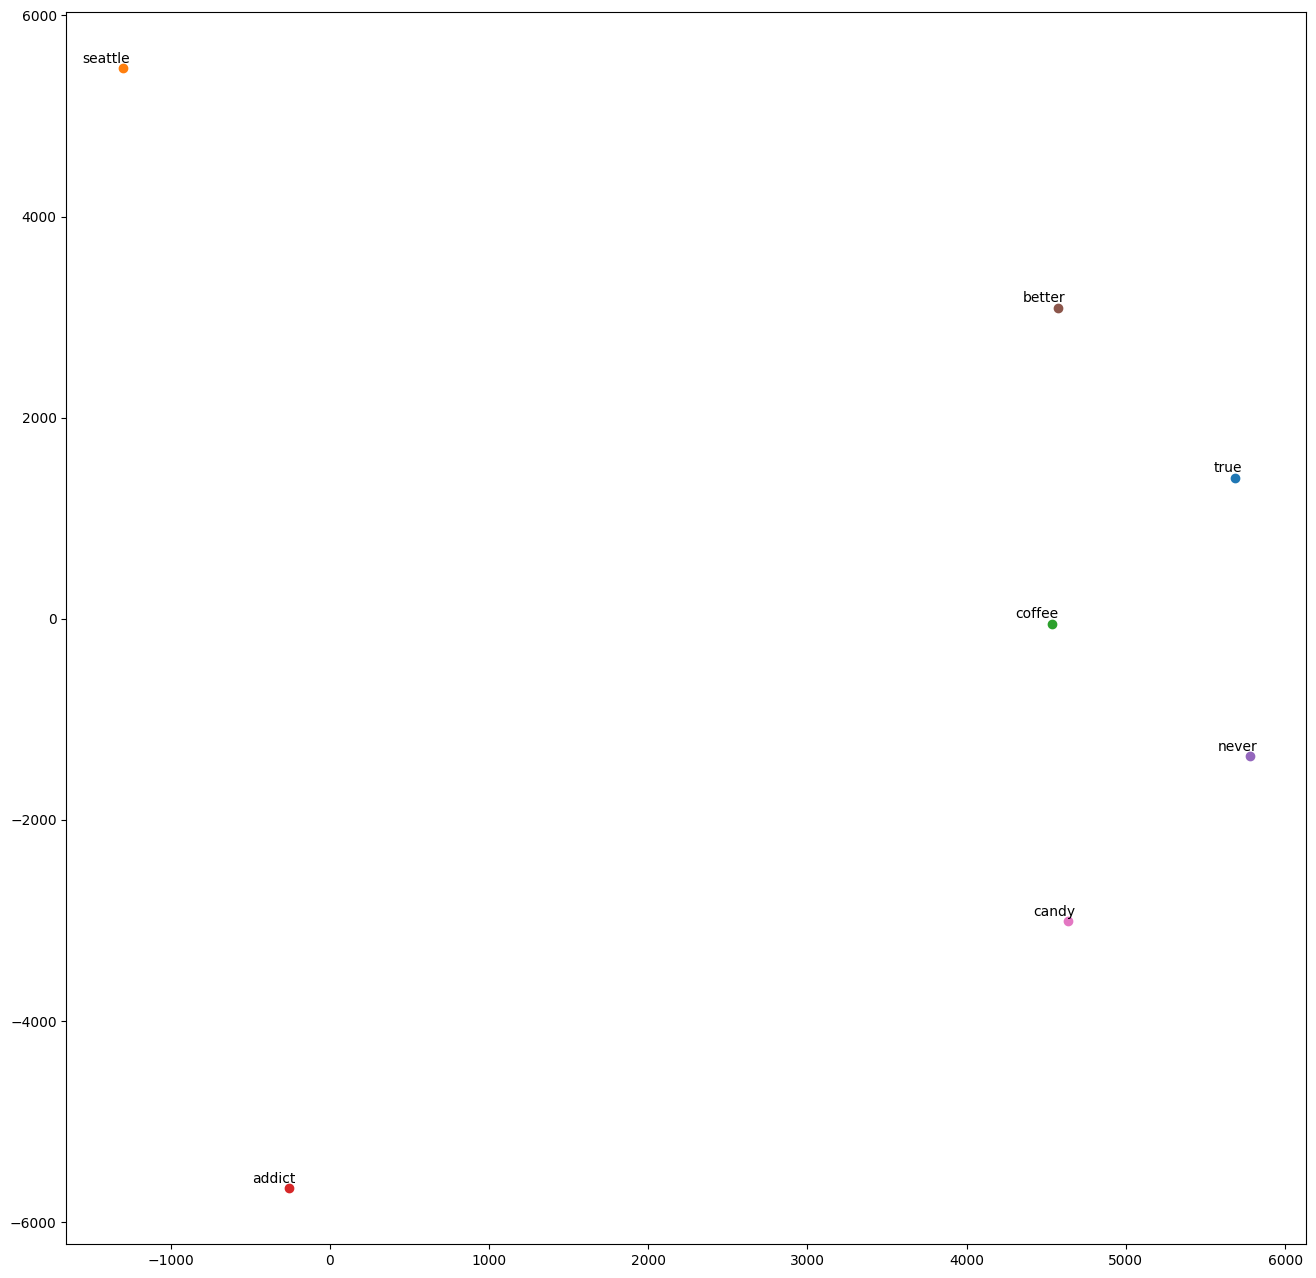




Rating: 5; Review: Much hotter than your normal green curry. One pack makes many servings.
Tokenized text word-to-vector 2D scatter plot:


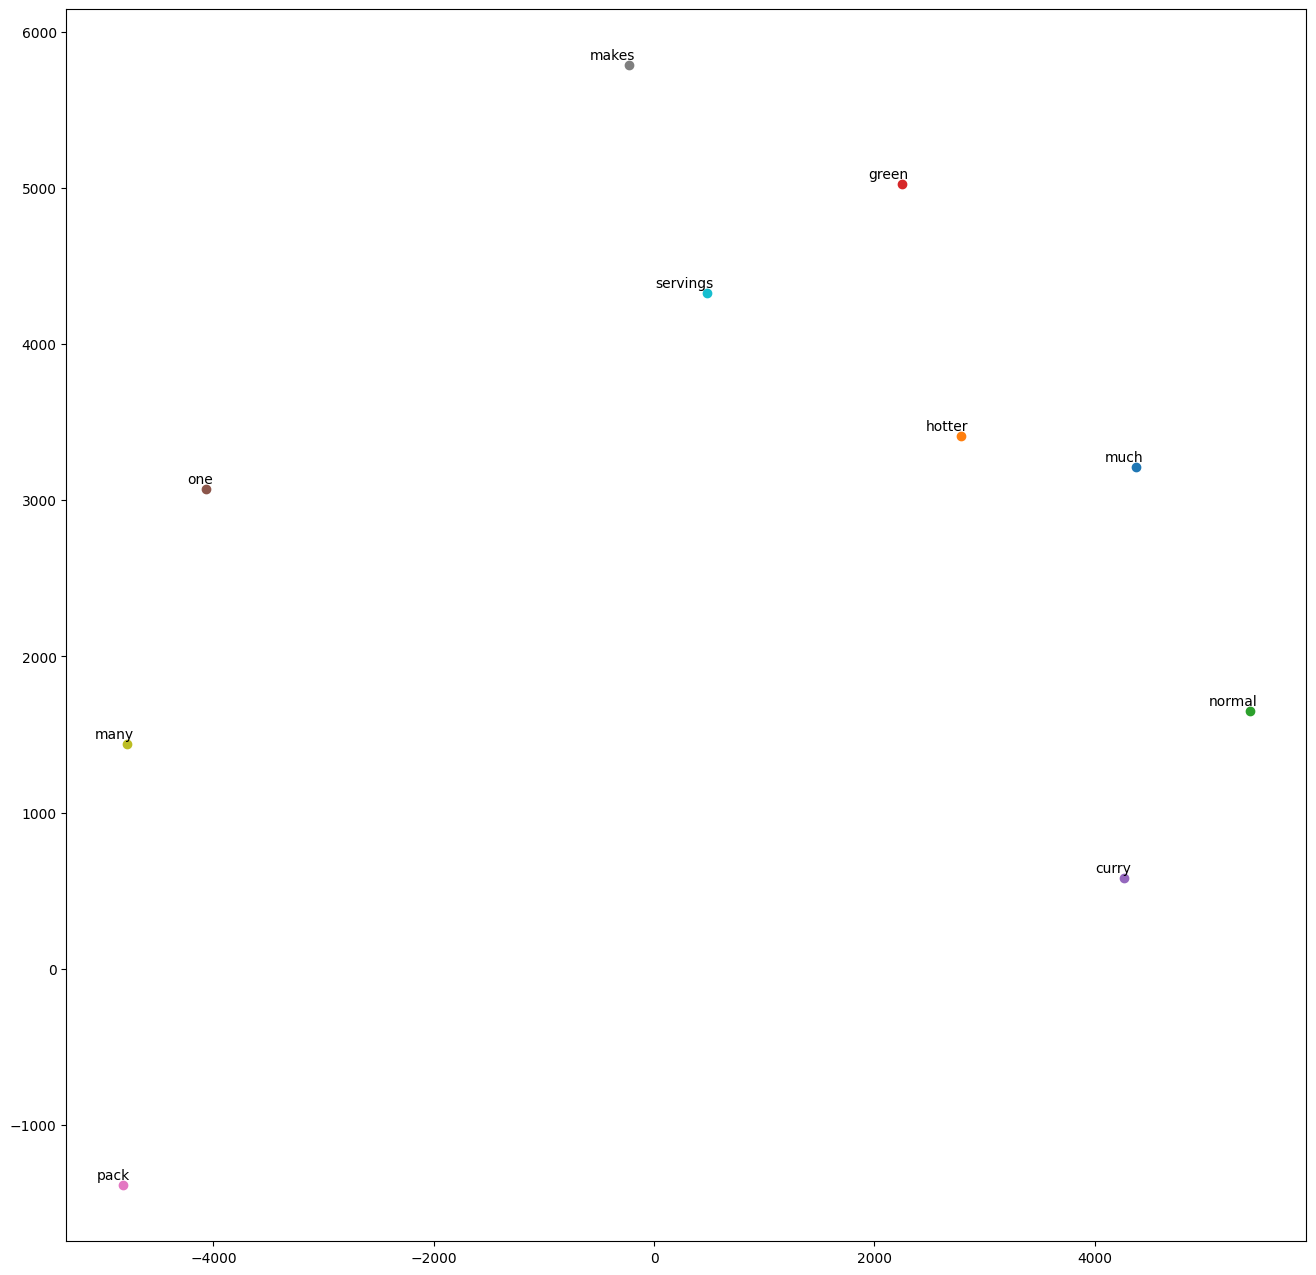




Rating: 1; Review: It didn't remove the spots... Now what am I going to do with all of the sponges I bought?
Tokenized text word-to-vector 2D scatter plot:


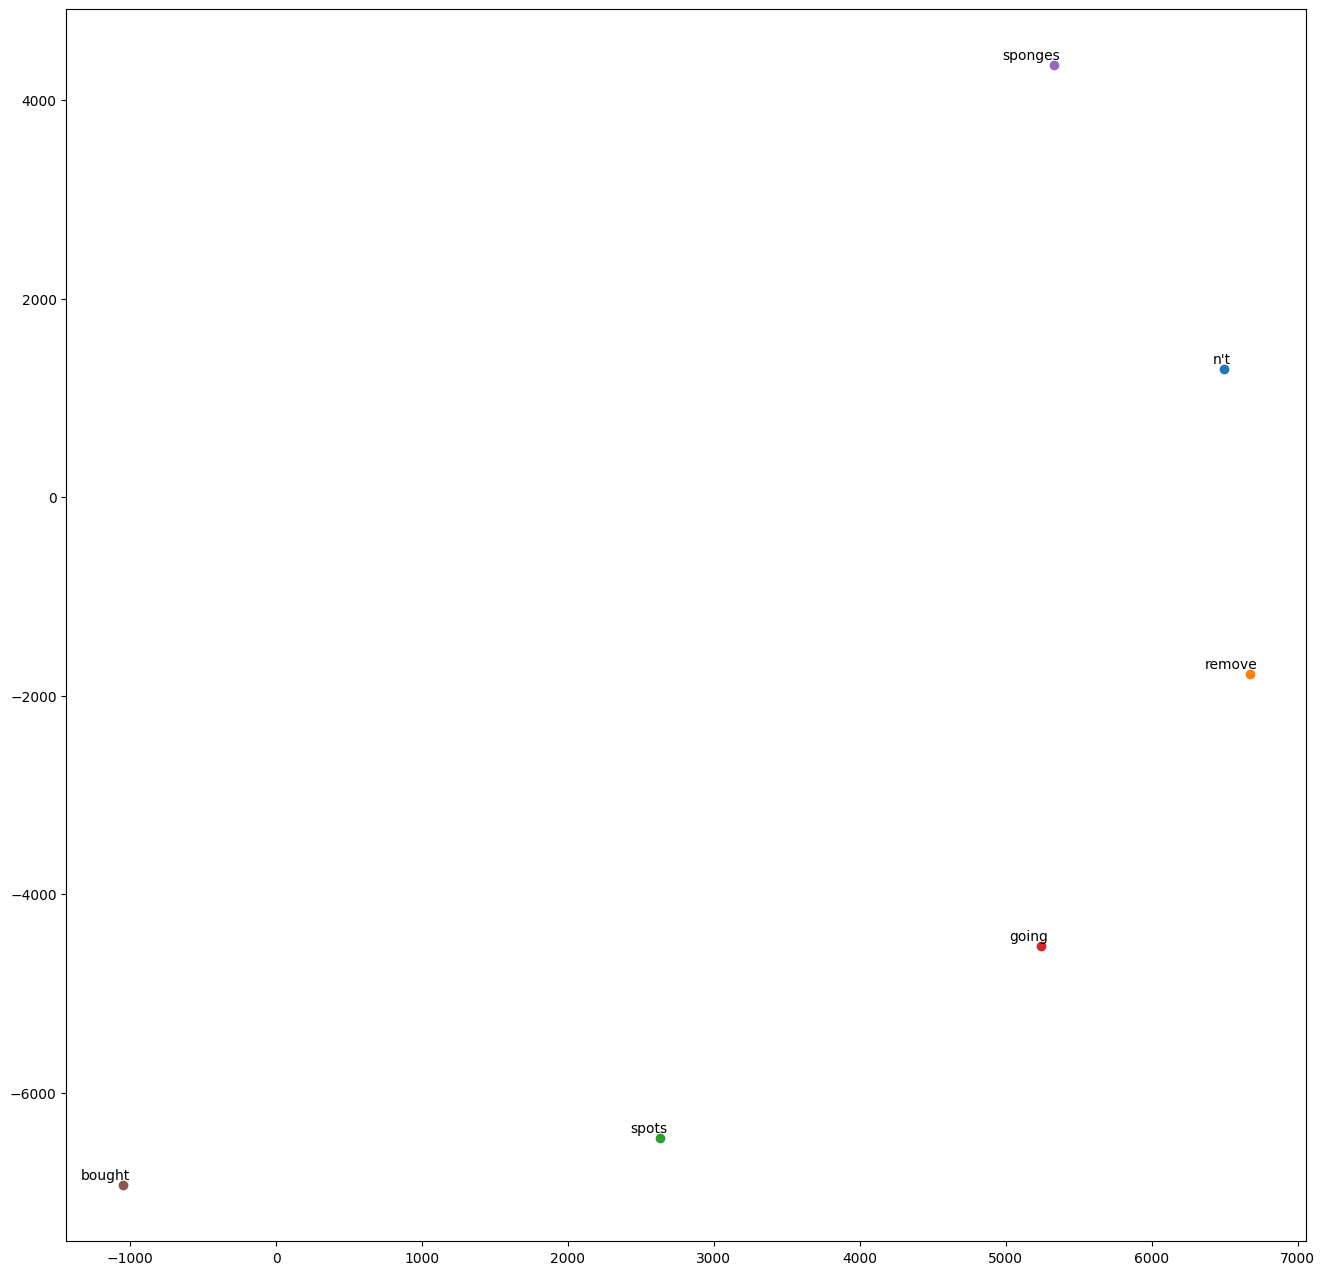




Rating: 1; Review: Are you supposed to avoid sugars if you have a urinary tract infection?
Tokenized text word-to-vector 2D scatter plot:


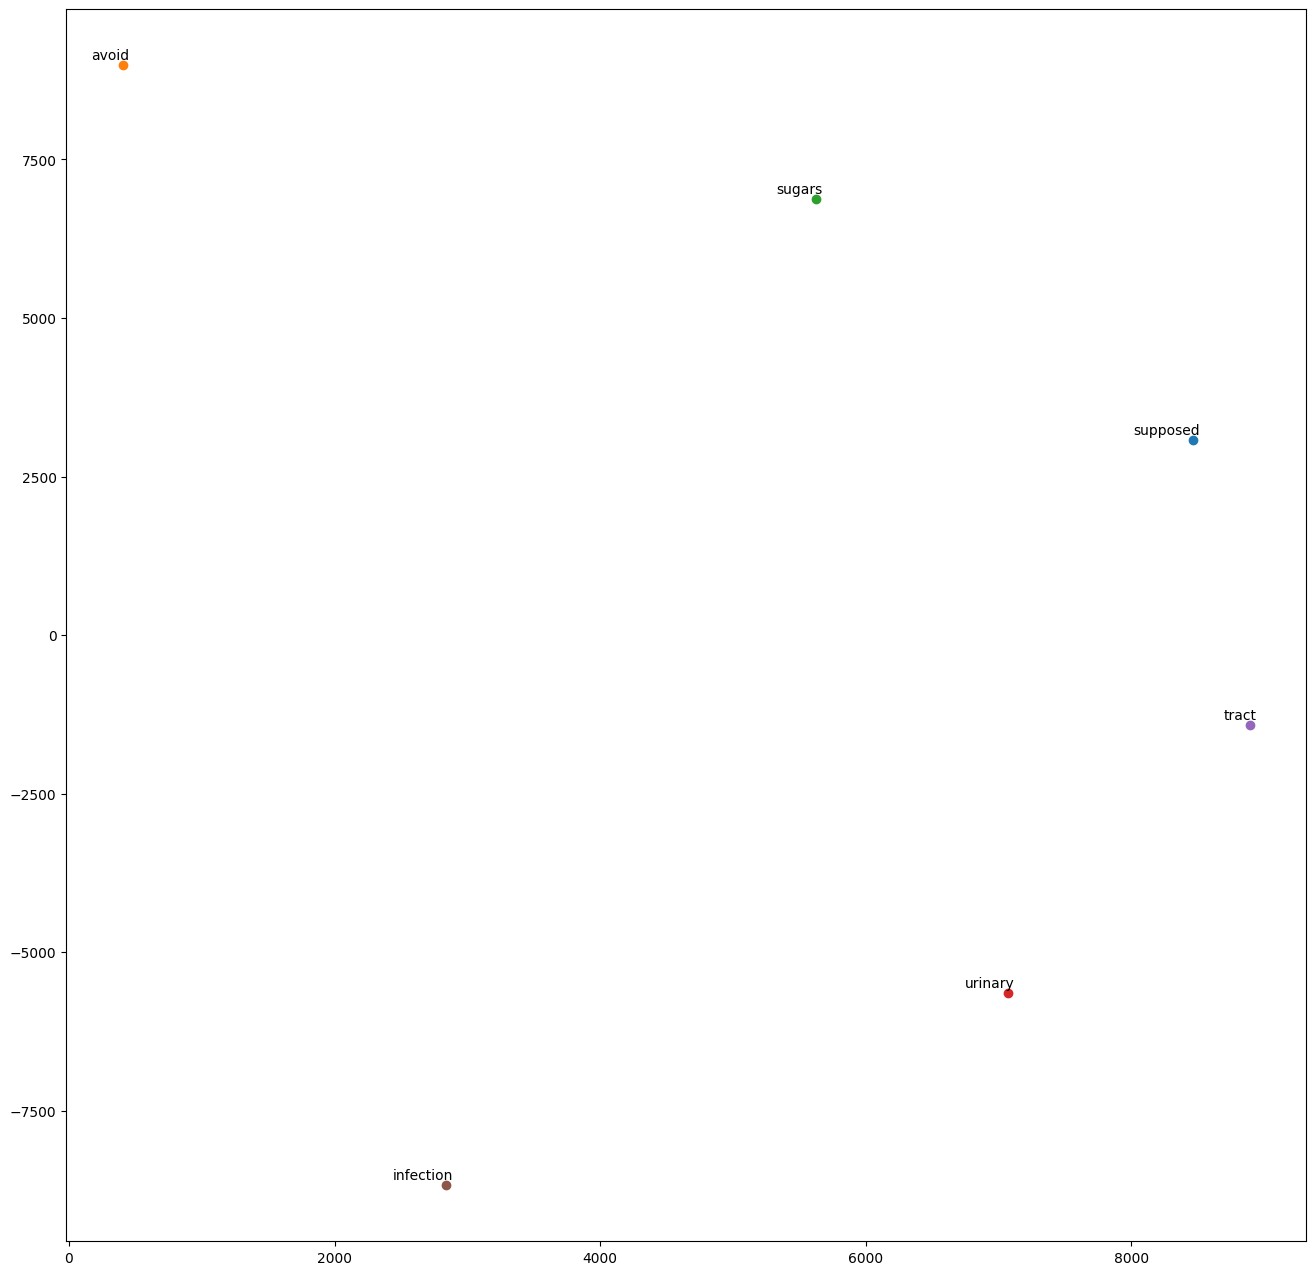




Rating: 1; Review: This is a great sweetener for Diabetics. Be careful though as I got extremly ill from it
Tokenized text word-to-vector 2D scatter plot:


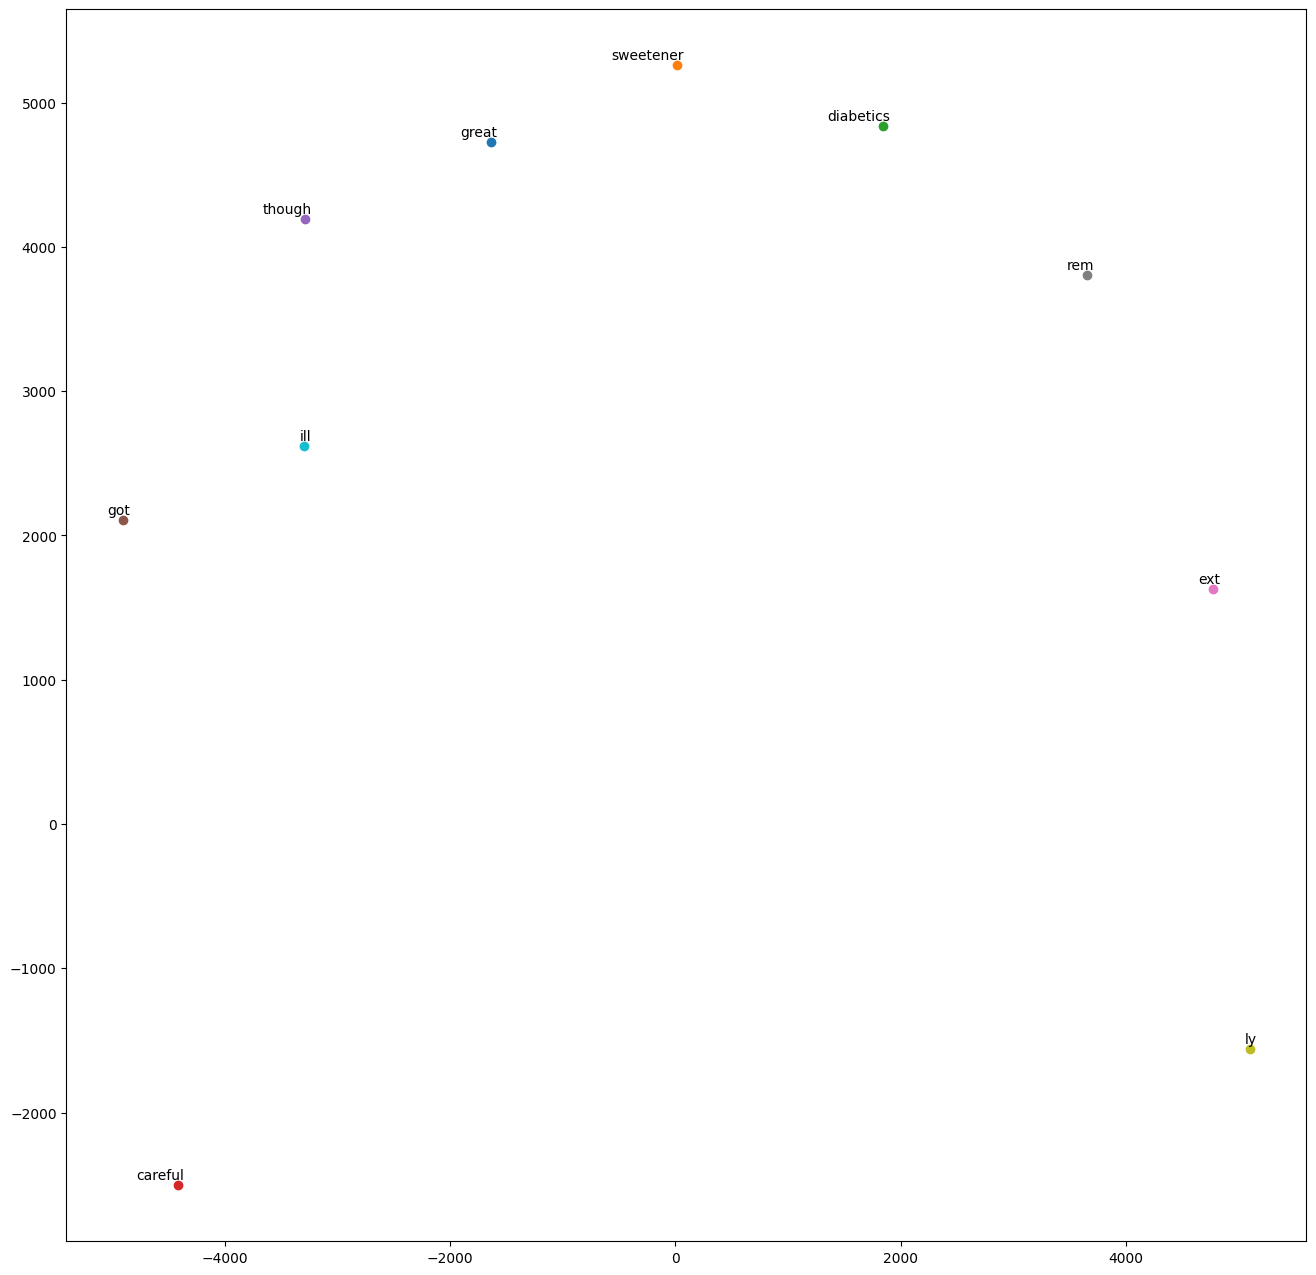

In [43]:
for idx in range(len(data_brief['CleanedReview'])):
    if idx != 0:
        print('\n\n')
    print(f'Rating: {data_brief["Score"][idx]};'+\
          f' Review: {data_brief["Text"][idx]}' )
    print('Tokenized text word-to-vector 2D scatter plot:')
    tsne_plot(text_embeddings_tensors[idx],data_brief['CleanedReview'][idx])